In [1]:
import pandas as pd
import concurrent.futures
import requests
import time
import numpy as np
import glob2 as glob
from unidecode import unidecode
import os
import logging
import cv2
import matplotlib.pyplot as plt

In [2]:
csv = pd.read_csv('annotations.csv')

In [3]:
csv.columns

Index(['palavra', 'video_url', 'filename', 'classe_gramatical', 'assunto',
       'configuracao_mao'],
      dtype='object')

In [4]:
csv['CM'] = (csv['configuracao_mao']).str.rsplit('/', 1).map(lambda x: x[1])
csv['CM'] = (csv['CM']).str.rsplit('.', 1).map(lambda x: x[0])

csv['filename'] = csv['filename'].map(lambda x:unidecode(x))
csv['filename'][652] = csv['filename'][652].rsplit('/', 1)[1]
csv['filename'][653] = csv['filename'][653].rsplit('/', 1)[1]

csv['palavra'] = (csv['filename']).map(lambda x:unidecode(x))
csv['palavra'] = (csv['palavra']).str.rsplit('.', 1).map(lambda x: x[0])
csv.to_csv('processedAnnotations.csv', index=False)

In [5]:
csv2 = csv.copy()
csv2['len_palavra'] = csv2['palavra'].map(lambda x:len(x))
csv2 = csv2[csv2['len_palavra'] > 0]
csv2 = csv2.drop(['video_url', 'configuracao_mao', 'filename', 'len_palavra'], axis=1)
csv2['letra'] = csv2['palavra'].map(lambda x:x[0])

In [6]:
csv2

,palavra,classe_gramatical,assunto,CM,letra
0,A,SUBSTANTIVO,NENHUM,cg01,A
1,ABACATE,SUBSTANTIVO,FRUTA,cg53a,A
2,ABACAXI,SUBSTANTIVO,FRUTA,cg47,A
3,ABAFAR,VERBO,NENHUM,cg07,A
4,ABAIXO,ADV.,NENHUM,cg62,A
...,...,...,...,...,...
5733,ZIGUEZAGUEAR,VERBO,NENHUM,cg62,Z
5734,ZIPER,SUBSTANTIVO,VESTUÁRIO/COMPLEMENTOS,cg05,Z
5735,ZOMBAR,VERBO,NENHUM,cg08a,Z
5736,ZOOLOGICO,ADJETIVO,NENHUM,cg14,Z


In [7]:
countLetters = csv2.groupby(['letra']).count()['palavra']
countLetters.to_csv('countWordsPerLetter.csv')

/home/fabiana/miniconda3/envs/opencv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [8]:
countCM = csv2.groupby(['CM']).count()['palavra']
countCM.to_csv('countWordsPerCM.csv')

/home/fabiana/miniconda3/envs/opencv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


Text(0.5, 1.0, 'Quantidade de palavras por configuração de mão')

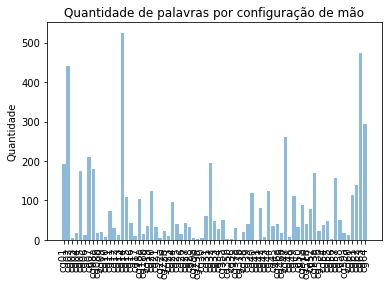

In [9]:
%matplotlib inline
y_pos = np.arange(len(countCM))
plt.bar(y_pos, countCM.values, align='center', alpha=0.5)
plt.xticks(y_pos, countCM.index, rotation='vertical')
plt.ylabel('Quantidade')
plt.title('Quantidade de palavras por configuração de mão')

Text(0.5, 1.0, 'Quantidade de palavras por letra do alfabeto')

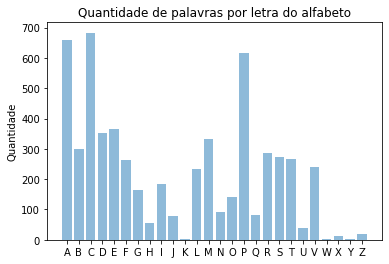

In [11]:
%matplotlib inline
y_pos = np.arange(len(countLetters))
plt.bar(y_pos, countLetters.values, align='center', alpha=0.5)
plt.xticks(y_pos, countLetters.index)
plt.ylabel('Quantidade')
plt.title('Quantidade de palavras por letra do alfabeto')

In [10]:
csv2.columns
csv2.to_csv('annotationsForVis.csv', index=False)

In [16]:
gp = csv2.groupby(['CM'])

In [20]:
gp['palavra'].count()

CM
cg01    193
cg02    442
cg03      4
cg04     17
cg05    174
       ... 
cg60     13
cg61    115
cg62    140
cg63    473
cg64    295
Name: palavra, Length: 73, dtype: int64

In [61]:
CONNECTIONS = 30
TIMEOUT = 5
labels = np.unique(csv['CM'])
urls_CM = np.unique(csv['configuracao_mao'])
urls_videos = csv['video_url']
filenames = csv['filename']

In [82]:
def load_url_images(url, index, folder):
    r = requests.get(url, allow_redirects=True)
    open(folder + labels[index] + '.jpg', 'wb').write(r.content)
    
def load_url_videos(url, index, folder):
    r = requests.get(url, allow_redirects=True)
    open(folder + filenames[index], 'wb').write(r.content)
    
def getAllFiles (pathToFiles):
    files = []
    files = glob.glob(pathToFiles + '/*/*.mp4', recursive=True)
    return files

### Downloading video files

In [86]:
with concurrent.futures.ThreadPoolExecutor(max_workers=CONNECTIONS) as executor:
    future_to_url = {executor.submit(load_url_videos, url, index, "Videos/") : url for index, url in enumerate(urls_videos)}
    time1 = time.time()
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            data = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))
        finally:
            csv.loc[csv['video_url'] == url, 'downloaded'] = 'ok'
            print(str(len(out)),end="\r")
            
    time2 = time.time()

print(f'Took {time2-time1:.2f} s')
print(pd.Series(out).value_counts())

### Creating inner directories so as to organize videos by alphabetical order

In [87]:
path = "/home/fabiana/Desktop/projeto-final-src/Crawler/Videos"
pfPath = "/home/fabiana/Desktop/projeto-final-src/Crawler"
files = getAllFiles(path)

In [88]:
for file in files:
    filename = file.rsplit('/', 1)[1]
    letter = filename[0]
    if (not os.path.isdir(path + '/' + letter)):
        os.mkdir(path + '/' + letter)
    os.rename(file, path + '/' + letter + '/' + filename)

### Creating log to keep track of corrupted files

In [89]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, 
    format='%(asctime)s [%(levelname)s] - %(message)s',
    filename="/home/fabiana/Desktop/projeto-final-src/Crawler/corruptedFiles.log",
   filemode='w')

for file in files:
    cap = cv2.VideoCapture(file)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if (length < 1):
        logging.error('There are no frames in ' + file)
cap.release()